In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
from matplotlib import pyplot as plt
import sys
import torch
import time

sys.path.append('/home/juravlik/PycharmProjects/kaggle_hnm_recsys/')


pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings("ignore")

/home/juravlik/anaconda3/envs/kaggle_hnm_recsys/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_transactions = pd.read_parquet('../../data/compressed_dataset/transactions.parquet')
df_articles = pd.read_parquet('../../data/compressed_dataset/articles.parquet')
df_customers = pd.read_parquet('../../data/compressed_dataset/customers.parquet')

article_id_int = pd.read_pickle('../../data/compressed_dataset/article_id_int.pickle')
int_article_id = pd.read_pickle('../../data/compressed_dataset/int_article_id.pickle')

customer_id_int = pd.read_pickle('../../data/compressed_dataset/customer_id_int.pickle')
int_customer_id = pd.read_pickle('../../data/compressed_dataset/int_customer_id.pickle')

In [3]:
print(df_articles["index_group_name"].unique())
print(df_articles["index_group_no"].unique())

['Ladieswear' 'Baby/Children' 'Menswear' 'Sport' 'Divided']
[ 1  4  3 26  2]


In [4]:
sex_category = df_articles[["index_group_no", "index_group_name"]].reset_index()
display(sex_category["index_group_name"].value_counts())

Ladieswear       39737
Baby/Children    34711
Divided          15149
Menswear         12553
Sport             3392
Name: index_group_name, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

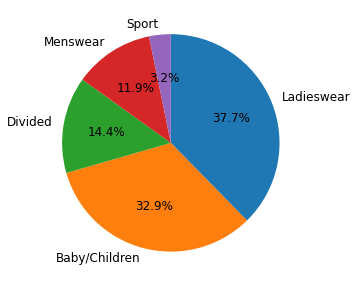

In [5]:
sex_category_list = sex_category["index_group_name"].value_counts().index.to_list()
plt.figure(figsize=(5, 5))
plt.rcParams["font.size"] = 12
plt.pie(sex_category["index_group_name"].value_counts().sort_values(ascending=False), 
        labels = sex_category_list, startangle = 90, counterclock=False, autopct="%1.1f%%")
plt.show

In [6]:
del sex_category_list

In [7]:
df_articles_category = pd.DataFrame(df_articles[["article_id", "index_group_no"]])
df_articles_category.columns = ["article_id", "sex_attribute"]
df_articles_category

,article_id,sex_attribute
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
105537,105537,3
105538,105538,1
105539,105539,1
105540,105540,2


In [8]:
df_transactions = pd.merge(df_transactions, df_articles_category, on = "article_id", how = "left")
df_transactions

,t_dat,customer_id,article_id,price,sales_channel_id,sex_attribute
0,2018-09-20,2,40179,0.050831,2,1
1,2018-09-20,2,10520,0.030492,2,1
2,2018-09-20,7,6387,0.015237,2,2
3,2018-09-20,7,46304,0.016932,2,1
4,2018-09-20,7,46305,0.016932,2,1
...,...,...,...,...,...,...
31788319,2020-09-22,1371691,104961,0.059305,2,2
31788320,2020-09-22,1371691,100629,0.042356,2,2
31788321,2020-09-22,1371721,104053,0.043203,1,1
31788322,2020-09-22,1371747,88521,0.006763,1,1


In [9]:
cust_sex = df_transactions[["customer_id", "sex_attribute", "article_id"]].groupby(["customer_id","sex_attribute"]).count().unstack()
cust_sex.columns = ["Woman", "Divided", "Man", "Children", "Sport"]
cust_sex

,Woman,Divided,Man,Children,Sport
customer_id,,,,,
0,13.0,2.0,1.0,5.0,NaN
1,62.0,19.0,NaN,4.0,1.0
2,12.0,1.0,4.0,NaN,1.0
3,NaN,NaN,NaN,NaN,2.0
4,11.0,NaN,NaN,NaN,2.0
...,...,...,...,...,...
1371975,46.0,NaN,1.0,NaN,4.0
1371976,27.0,48.0,2.0,7.0,NaN
1371977,19.0,18.0,5.0,NaN,3.0


In [10]:
# cust_sex.reset_index(inplace=True, drop=True)

cust_sex['sex'] = 'Divided'

cust_sex.loc[(cust_sex['Woman'] > cust_sex['Man'])
             | ((~cust_sex['Woman'].isnull())
                & (cust_sex['Man'].isnull())), "sex"] = 'Woman'


cust_sex.loc[(cust_sex['Woman'] < cust_sex['Man'])
             | ((cust_sex['Woman'].isnull())
                & (~cust_sex['Man'].isnull())), "sex"] = 'Man'

cust_sex['have_children'] = 0
cust_sex.loc[cust_sex.Children > 8, "have_children"] = 1

cust_sex['sport_person'] = 0
cust_sex.loc[cust_sex.Sport > 8, "sport_person"] = 1

In [11]:
cust_sex['sex'].value_counts()

Woman      1159145
Divided     139202
Man          63934
Name: sex, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

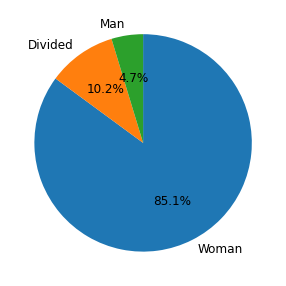

In [12]:
temp = cust_sex["sex"].value_counts().index.to_list()
plt.figure(figsize=(5, 5))
plt.rcParams["font.size"] = 12
plt.pie(cust_sex["sex"].value_counts().sort_values(ascending=False), 
        labels = temp, startangle = 90, counterclock=False, autopct="%1.1f%%")
plt.show

In [13]:
cust_sex.reset_index(inplace=True)

In [14]:
df_customers = df_customers.merge(cust_sex[['customer_id',
                                            'sex',
                                            'have_children',
                                            'sport_person']],
                                  on ="customer_id", how="left")
df_customers

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,sex,have_children,sport_person
0,0,NaN,NaN,ACTIVE,NONE,49.0,0,Woman,0.0,0.0
1,1,NaN,NaN,ACTIVE,NONE,25.0,1,Woman,0.0,0.0
2,2,NaN,NaN,ACTIVE,NONE,24.0,2,Woman,0.0,0.0
3,3,NaN,NaN,ACTIVE,NONE,54.0,3,Divided,0.0,0.0
4,4,1.0,1.0,ACTIVE,Regularly,52.0,4,Woman,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1371975,1371975,NaN,NaN,ACTIVE,NONE,24.0,62927,Woman,0.0,0.0
1371976,1371976,NaN,NaN,ACTIVE,NONE,21.0,6316,Woman,0.0,0.0
1371977,1371977,1.0,1.0,ACTIVE,Regularly,21.0,273671,Woman,0.0,0.0
1371978,1371978,1.0,1.0,ACTIVE,Regularly,18.0,218323,Woman,0.0,0.0


In [15]:
df_customers["sex"].fillna("Woman", inplace = True)
df_customers["have_children"].fillna(0, inplace = True)
df_customers["sport_person"].fillna(0, inplace = True)

In [16]:
df_customers['sex_Woman'] = 0
df_customers.loc[df_customers.sex == 'Woman', 'sex_Woman'] = 1

df_customers['sex_Man'] = 0
df_customers.loc[df_customers.sex == 'Man', 'sex_Man'] = 1

df_customers['sex_Divided'] = 0
df_customers.loc[df_customers.sex == 'Divided', 'sex_Divided'] = 1

In [17]:
df_customers

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,sex,have_children,sport_person,sex_Woman,sex_Man,sex_Divided
0,0,NaN,NaN,ACTIVE,NONE,49.0,0,Woman,0.0,0.0,1,0,0
1,1,NaN,NaN,ACTIVE,NONE,25.0,1,Woman,0.0,0.0,1,0,0
2,2,NaN,NaN,ACTIVE,NONE,24.0,2,Woman,0.0,0.0,1,0,0
3,3,NaN,NaN,ACTIVE,NONE,54.0,3,Divided,0.0,0.0,0,0,1
4,4,1.0,1.0,ACTIVE,Regularly,52.0,4,Woman,0.0,0.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371975,1371975,NaN,NaN,ACTIVE,NONE,24.0,62927,Woman,0.0,0.0,1,0,0
1371976,1371976,NaN,NaN,ACTIVE,NONE,21.0,6316,Woman,0.0,0.0,1,0,0
1371977,1371977,1.0,1.0,ACTIVE,Regularly,21.0,273671,Woman,0.0,0.0,1,0,0
1371978,1371978,1.0,1.0,ACTIVE,Regularly,18.0,218323,Woman,0.0,0.0,1,0,0


In [19]:
df_customers[['customer_id',
              'sex_Woman', 'sex_Man', 'sex_Divided',
              'have_children',
              'sport_person']].to_parquet('/home/juravlik/PycharmProjects/kaggle_hnm_recsys/data/features/customers/static/sex_children_sport_type_purchases.parquet',
                                                               index=False)

In [20]:
df_cust = df_customers[['customer_id',
              'sex_Woman', 'sex_Man', 'sex_Divided',
              'have_children',
              'sport_person']]

In [21]:
df_cust

,customer_id,sex_Woman,sex_Man,sex_Divided,have_children,sport_person
0,0,1,0,0,0.0,0.0
1,1,1,0,0,0.0,0.0
2,2,1,0,0,0.0,0.0
3,3,0,0,1,0.0,0.0
4,4,1,0,0,0.0,0.0
...,...,...,...,...,...,...
1371975,1371975,1,0,0,0.0,0.0
1371976,1371976,1,0,0,0.0,0.0
1371977,1371977,1,0,0,0.0,0.0
1371978,1371978,1,0,0,0.0,0.0


In [22]:
df_transactions

,t_dat,customer_id,article_id,price,sales_channel_id,sex_attribute
0,2018-09-20,2,40179,0.050831,2,1
1,2018-09-20,2,10520,0.030492,2,1
2,2018-09-20,7,6387,0.015237,2,2
3,2018-09-20,7,46304,0.016932,2,1
4,2018-09-20,7,46305,0.016932,2,1
...,...,...,...,...,...,...
31788319,2020-09-22,1371691,104961,0.059305,2,2
31788320,2020-09-22,1371691,100629,0.042356,2,2
31788321,2020-09-22,1371721,104053,0.043203,1,1
31788322,2020-09-22,1371747,88521,0.006763,1,1


In [25]:
for group, df in df_cust.groupby(['sex_Woman', 'sex_Man', 'sex_Divided', 'have_children', 'sport_person']):
    print(group)

(0, 0, 1, 0.0, 0.0)
(0, 0, 1, 0.0, 1.0)
(0, 0, 1, 1.0, 0.0)
(0, 0, 1, 1.0, 1.0)
(0, 1, 0, 0.0, 0.0)
(0, 1, 0, 0.0, 1.0)
(0, 1, 0, 1.0, 0.0)
(0, 1, 0, 1.0, 1.0)
(1, 0, 0, 0.0, 0.0)
(1, 0, 0, 0.0, 1.0)
(1, 0, 0, 1.0, 0.0)
(1, 0, 0, 1.0, 1.0)


In [26]:
df_cust

,customer_id,sex_Woman,sex_Man,sex_Divided,have_children,sport_person
0,0,1,0,0,0.0,0.0
1,1,1,0,0,0.0,0.0
2,2,1,0,0,0.0,0.0
3,3,0,0,1,0.0,0.0
4,4,1,0,0,0.0,0.0
...,...,...,...,...,...,...
1371975,1371975,1,0,0,0.0,0.0
1371976,1371976,1,0,0,0.0,0.0
1371977,1371977,1,0,0,0.0,0.0
1371978,1371978,1,0,0,0.0,0.0


In [109]:
customers_by_group = []
popular_by_group = []
scores_by_group = []

for group, df in df_cust.groupby(['sex_Woman', 'sex_Man', 'sex_Divided']):
    cur_customers = df['customer_id'].tolist()
    df_cur_trans = df_transactions[df_transactions['customer_id'].isin(cur_customers)]
        
    customers_by_group.append(cur_customers)
    popular_by_group.append(list(df_cur_trans['article_id'].value_counts().index))
    scores_by_group.append(list(df_cur_trans['article_id'].value_counts() /
                               df_cur_trans['article_id'].value_counts().iloc[0]))

In [114]:
selected_customers = df_cust['customer_id'].sample(1000).tolist()

In [115]:
predict_customers = []
predict_articles = []
predict_scores = []

In [116]:
%%time

for i in range(len(customers_by_group)):        
    for customer in list(set(selected_customers) & set(customers_by_group[i])):

        predict_articles += popular_by_group[i][:12]
        predict_scores += scores_by_group[i][:12]
        predict_customers += [customer] * len(popular_by_group[i][:12])
        

CPU times: user 36.4 ms, sys: 38 µs, total: 36.5 ms
Wall time: 35.7 ms
